# Assignment 1c Notebook: Constraint Satisfaction EA
This notebook is part of Assignment 1c, which will guide you through half of this two-part assignment: building a constraint satisfaction EA. This assignment builds on the EA code you wrote in Assignment 1b; therefore, if this is the first notebook you're filling out for Assignment 1c, you should copy over the following files:
* 1a_notebook.ipynb
* 1b_notebook.ipynb
* base_evolution.py
* bridge_population_evaluation.py
* linear_genotype.py
* selection.py

*Be careful* to not copy over functions relating to the provided fitness functions or bridge structures (files you shouldn't have modified anyways). We may have changed those and we want you to have the versions that were provided with this repo.

As usual, be sure to **read all of this notebook** and you can start by executing the next cell.

In [6]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore') # hopefully stop any pedantic warnings

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

print('The first cell has been executed!')

The first cell has been executed!


## Bridge Builder Constraint: Exclusion Zones
We have changed the `basic_simulation` fitness function from Assignments 1a and 1b to enable the reduction of gravity if a bridge is unable to support its own weight and these bridges now receive a negative fitness value proportional to the amount of gravity relaxation required. Bridges that cannot support their own weight (due to the use of heavier materials like steel) were originally intended to be the focus of this constraint satisfaction assignment. Upon closer inspection, this criteria doesn't really showcase a good scenario to deploy constraint satisfaction as it's too directly related to the weight a bridge can support before failing.

Instead, we ask that you evolve bridges with clearings for boats and other forms of traffic to pass through. These clearings are now defined as exclusion zones in the problem instance parameters of your config and we're providing a new fitness function that also counts the number of bridge elements that intersect with the exclusion zone(s).

## Constraint satisfaction
You may recall from the lectures that there are multiple ways to handle constraints in an EA. You can employ the following techniques:
* ignore constraints
* kill invalid offspring
* feasible phenotype mapping decoder
* repair function
* feasible solution space closed under variation operators
* penalty function

For this assignment, we're going to guide you through the process of implementing two of these techniques: a vanilla EA that ignores the constraints (uses large negative fitness if constraints are violated) and a constraint satisfaction EA using a penalty function. This means that fitness will reflect not only the amount of weight a bridge can support before failing, but also how well it obeys other problem constraints. Consequently, evolution will (hopefully) evolve bridges that are capable of supporting increasing weight *and* satisfying the design constraints.

Recall that `basic_simulation` returns the weight at which the bridge failed and the assembled bridge. In this assignment, we will instead use `constraint_satisfaction_simulation` which returns three values: the weight at which the bridge fails, *the number of constraint violations in the solution*, and the representation of the bridge itself (for vizualization).

The following cell demonstrates how to obtain these values using this new functionality.

The solution's raw fitness was -100,000,000
The solution's unpenalized fitness was -100,000,000.0
Constraint violations: 9
The solution's penalized fitness was -100,900,000.0


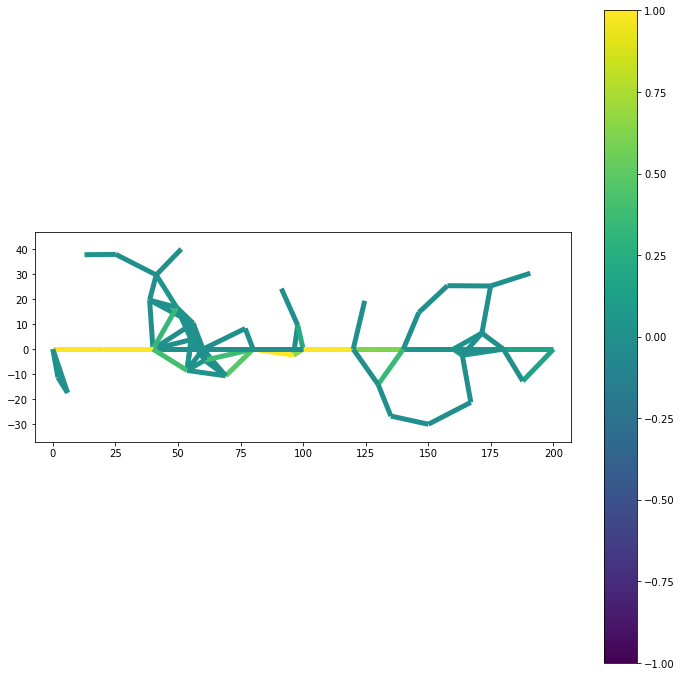

In [7]:
from selection import *
from snake_eyes import read_config
from linear_genotype import LinearGenotype
from bridge_fitness import constraint_satisfaction_simulation, plot_bridge, WORST_FITNESS

config = read_config('./configs/green1c0_penalty_config.txt', globalVars=globals(), localVars=locals())
penalty_coefficient = config['fitness_kwargs']['penalty_coefficient'] # we'll present a more graceful way of accessing this

test_solution = LinearGenotype()
test_solution.random_initialization(**config['initialization_kwargs'])

test_solution.raw_fitness, unpenalized_fitness, violations, bridge \
                        = constraint_satisfaction_simulation(test_solution.gene, **config['fitness_kwargs'])

test_solution.penalized_fitness = unpenalized_fitness - penalty_coefficient * violations

print(f"The solution's raw fitness was {test_solution.raw_fitness:,}")
print(f"The solution's unpenalized fitness was {unpenalized_fitness:,}")
print(f'Constraint violations: {violations:,}')
print(f"The solution's penalized fitness was {test_solution.penalized_fitness:,}")
plot_bridge(bridge)

del config, test_solution # to discourage haphazard copypasta

Note that we assigned the new member variables `raw_fitness` and `penalized_fitness`. The `raw_fitness` definition of fitness assigns an arbitrarily large negative value if the solution is invalid (i.e., does not satisfy the design constraints) and otherwise assigns standard fitness. If ignoring the design constraints, we will use raw fitness for evolution (i.e., `test_solution.fitness = test_solution.raw_fitness`). Otherwise, we still calculate and assign `raw_fitness` for use in later statistical analysis, but we'll use penalized fitness for evolution (i.e., `test_solution.fitness = test_solution.penalized_fitness`).

To be abundantly clear: **it is invalid to directly compare different calculations of fitness in your statistical analysis!** We will discuss this in more detail later in the notebook. For now, just know that this value needs to be stored as a member in your solutions.

Now that we've demonstrated how to calculate raw and penalized fitness, it's your turn to write a function that evaluates an input population and assigns `raw_fitness` and `penalized_fitness` to each individual. Complete the `constraint_satisfaction_population_evaluation` function inside `bridge_population_evaluation.py`. Notice that the inputs are a little different than the function you completed during Assignment 1b and this function will strip off the `penalty_coefficient` parameter and pass all other keyword arguments into a dictionary you can use with `**fitness_kwargs`. This function should be very similar to the `basic_population_evaluation` function you wrote for Assignment 1b.

Individuals with unassigned penalized fitness: 0
Individuals with unassigned raw fitness: 0
Average penalized fitness of population: -99,970,000.0
Best penalized fitness in population: -98,000,000.0
Average raw fitness of population: -100000000.0
Best raw fitness in population: -100,000,000


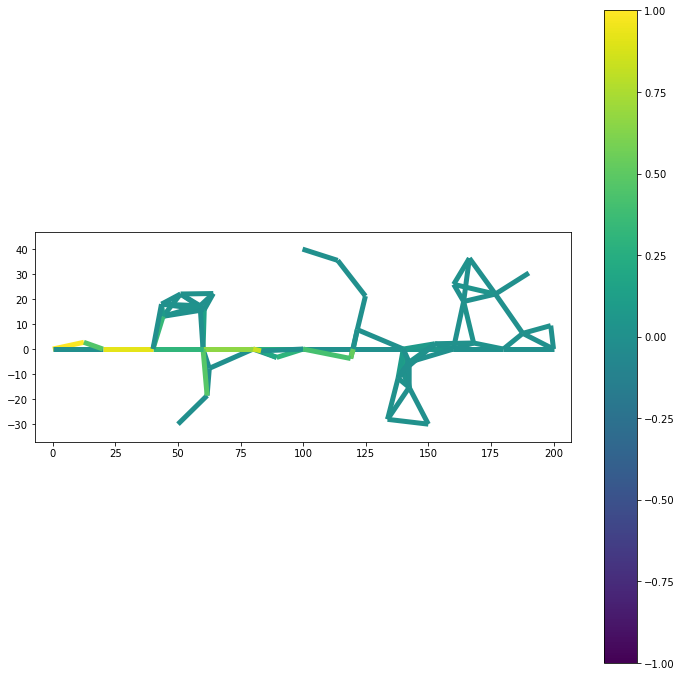

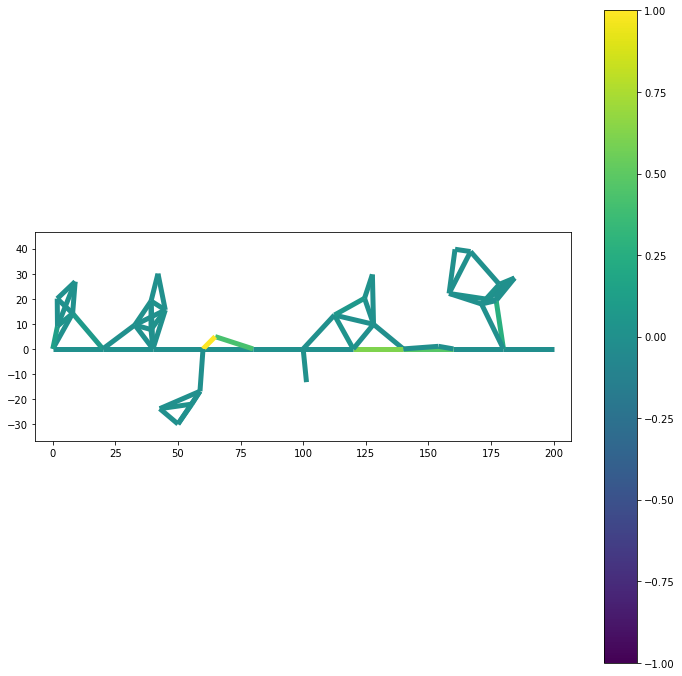

In [8]:
import statistics
import numpy as np
from bridge_population_evaluation import constraint_satisfaction_population_evaluation

config = read_config('./configs/green1c0_penalty_config.txt', globalVars=globals(), localVars=locals())

example_population = LinearGenotype.initialization(10, **config['initialization_kwargs'])

# Note explicitly initializing to None is unnecessary in general
# We only do it here to test that you've actually set these values
for individual in example_population:
    individual.raw_fitness = None
    individual.penalized_fitness = None

# calling your function to test things out
constraint_satisfaction_population_evaluation(example_population, **config['fitness_kwargs'])

unassigned=len([individual.penalized_fitness for individual in example_population if individual.penalized_fitness is None])
print(f'Individuals with unassigned penalized fitness: {unassigned}')
passed = unassigned == 0
unassigned=len([individual.raw_fitness for individual in example_population if individual.raw_fitness is None])
print(f'Individuals with unassigned raw fitness: {unassigned}')
passed = passed and unassigned == 0
if passed:
    penalized_fitnesses = [individual.penalized_fitness for individual in example_population]
    print(f'Average penalized fitness of population: {statistics.mean(penalized_fitnesses):,}')
    print(f'Best penalized fitness in population: {max(penalized_fitnesses):,}')
    plot_bridge(example_population[np.argmax(penalized_fitnesses)].bridge)
    raw_fitnesses = [individual.raw_fitness for individual in example_population]
    print(f'Average raw fitness of population: {statistics.mean(raw_fitnesses)}')
    print(f'Best raw fitness in population: {max(raw_fitnesses):,}')
    plot_bridge(example_population[np.argmax(raw_fitnesses)].bridge)
    del penalized_fitnesses, raw_fitnesses
else:
    print('Ensure the entire population is evaluated then execute this cell again')
del config, example_population, unassigned # to discourage haphazard copypasta

### Helper Function: assign_fitness
In assignments 1a and 1b, we guided you through assigning a `fitness` member variable to each individual in the population and your EA presumably operates on the assumption that this member variable is populated for use in your selection algorithms. Since your selection operators already function with negative fitness, we can simply change how the `fitness` member variable is assigned and the EA components you implemented in Assignment 1b should *just work*. Neat!

To facilitate that operation, we're providing the following helper function to assign `fitness` within a population as `raw_fitness` or `penalized_fitness` based on an input parameter defined in your config files. Execute the following cell to define this function for later use in your full EA.

In [9]:
def assign_fitness(population, method):
    assert isinstance(method, str) and method.casefold() in {'penalty', 'ignore'},\
    f'Encountered unknown constraint handling method {method}'
    if method.casefold() == 'penalty':
        for individual in population:
            individual.fitness = individual.penalized_fitness
    else:
        # this is the ignore constraint approach
        for individual in population:
            individual.fitness = individual.raw_fitness

In [10]:
from base_evolution import BaseEvolutionPopulation

print('Config file for using a penalty function')
config = read_config('./configs/green1c0_penalty_config.txt', globalVars=globals(), localVars=locals())
example_EA = BaseEvolutionPopulation(**config['EA_configs'], **config)
constraint_satisfaction_population_evaluation(example_EA.population, **config['fitness_kwargs'])

assign_fitness(example_EA.population, **config['constraint_handling'])
fitnesses = [ind.fitness for ind in example_EA.population]
print(f'Best penalized fitness: {max(fitnesses)}')
print(f'Average penalized fitness: {statistics.mean(fitnesses)}')

print('\nConfig file for ignoring constraints')
config = read_config('./configs/green1c0_ignore_config.txt', globalVars=globals(), localVars=locals())
assign_fitness(example_EA.population, **config['constraint_handling'])
fitnesses = [ind.fitness for ind in example_EA.population]
print(f'Best raw fitness: {max(fitnesses)}')
print(f'Average raw fitness: {statistics.mean(fitnesses)}')

del config, example_EA, fitnesses

Config file for using a penalty function
Best penalized fitness: -64400000.0
Average penalized fitness: -98972600.0

Config file for ignoring constraints
Best raw fitness: -85000000.0
Average raw fitness: -99878000.0


## Assembling your EA
Now you get to use the framework you implemented in Assignment 1b to build a constraint satisfaction EA!

As usual, we'll have you start out by performing a single run of your EA that performs 5,000 evaluations. Note that this cell can be nearly identical to a cell from Assignment 1b's notebook, except for the calls to `constraint_satisfaction_population_evaluation` and `assign_fitness`. Another key difference is that you'll want to perform all logging using the `raw_fitness` of your population instead of `fitness` so we have a consistent metric to perform statistical analysis with.

In [27]:
from math import inf

def constraint_satisfaction_EA_search(run_number, number_evaluations, config_filename):
    # Parse the config and implement your EA here.
    # Feel free to focus on implementation first and then return for data collection.
    best_fitness = -inf
    ave_fitness = 0
    data = None
    config = read_config(config_filename, globalVars=globals(), localVars=locals())
    evalNum = 0
    bestFitnessEval = 0
    filepath = None
    
    if 'penalty' in config_filename:
        filepath = 'data/1c_notebook0/penalty/run' + str(run_number) + '/'
    else:
        filepath = 'data/1c_notebook0/ignore/run' + str(run_number) + '/'
    
    # initialization 
    evoAlgo = BaseEvolutionPopulation(**config['EA_configs'], **config)
    constraint_satisfaction_population_evaluation(evoAlgo.population, **config['fitness_kwargs'])
    evoAlgo.evaluations = len(evoAlgo.population)
    assign_fitness(evoAlgo.population, **config['constraint_handling'])
    fitnesses = [ind.fitness for ind in evoAlgo.population]
    
    with open(filepath + 'gens.txt', 'w') as fp:
        fp.write('Initialization\n')
        fp.write(f'Number of fitness evaluations: {evoAlgo.evaluations}\n')
        
        # switch to raw fitness for logging
        if 'penalty' in config_filename:
            config = read_config('./configs/green1c0_ignore_config.txt', globalVars=globals(), localVars=locals())
            fitnesses = [ind.fitness for ind in evoAlgo.population]
            assign_fitness(evoAlgo.population, **config['constraint_handling'])
        
        fp.write(f'Best raw fitness: {max(fitnesses)}\n')
        fp.write(f'Average raw fitness: {statistics.mean(fitnesses)}\n')
        fp.write(f'Average fitness of population: {statistics.mean([individual.fitness for individual in evoAlgo.population]):,}\n')
        fp.write(f'Best fitness in population: {max([individual.fitness for individual in evoAlgo.population]):,}\n')
        fp.write('------------------------\n')
    
    if 'penalty' in config_filename:
        # switch back to penalized fitness for evolution
        config = read_config(config_filename, globalVars=globals(), localVars=locals())
        assign_fitness(evoAlgo.population, **config['constraint_handling'])
    
        
    while not(evalNum == number_evaluations):
        # generate children
        children = evoAlgo.generate_children()
        constraint_satisfaction_population_evaluation(children, **config['fitness_kwargs'])
        evoAlgo.evaluations += len(children)
        assign_fitness(children, **config['constraint_handling'])
        fitnesses = [child.fitness for child in children]
        
        # (𝜇 + 𝜆)
        evoAlgo.population += children
        
        with open(filepath + 'gens.txt', 'a') as fp:
            fp.write(f'Number of fitness evaluations: {evoAlgo.evaluations}\n')
        
            # switch to raw fitness for logging
            if 'penality' in config_filename:
                config = read_config('./configs/green1c0_ignore_config.txt', globalVars=globals(), localVars=locals())
                fitnesses = [ind.fitness for ind in evoAlgo.population]
                assign_fitness(evoAlgo.population, **config['constraint_handling'])
        
            fp.write(f'Best raw fitness: {max(fitnesses)}\n')
            fp.write(f'Average raw fitness: {statistics.mean(fitnesses)}\n')
            fp.write(f'Average fitness of population: {statistics.mean([individual.fitness for individual in evoAlgo.population]):,}\n')
            fp.write(f'Best fitness in population: {max([individual.fitness for individual in evoAlgo.population]):,}\n')
            fp.write('------------------------\n')
    
        if 'penality' in config_filename:
            # switch back to penalized fitness for evolution
            config = read_config(config_filename, globalVars=globals(), localVars=locals())
            assign_fitness(evoAlgo.population, **config['constraint_handling'])
        
        # survival selection
        evoAlgo.survival()
        
        # switch to raw fitness for logging
        if 'penality' in config_filename:
            config = read_config('./configs/green1c0_ignore_config.txt', globalVars=globals(), localVars=locals())
            fitnesses = [ind.fitness for ind in evoAlgo.population]
            assign_fitness(evoAlgo.population, **config['constraint_handling'])
        
        if(max([individual.fitness for individual in evoAlgo.population]) > best_fitness):
            best_fitness = max([individual.fitness for individual in evoAlgo.population])
            bestFitnessEval = evalNum
            #print(f'Generation Number: {evalNum}')
            #print(f'Best Fitness: {best_fitness}')
            data = individual.bridge
        
        ave_fitness = (ave_fitness + statistics.mean([individual.fitness for individual in evoAlgo.population])) / (evalNum+1)
        
        evalNum += 1
        
        if 'penality' in config_filename:
            # switch back to penalized fitness for evolution
            config = read_config(config_filename, globalVars=globals(), localVars=locals())
            assign_fitness(evoAlgo.population, **config['constraint_handling'])
        
    
    return [best_fitness, ave_fitness, data]
        


In [23]:
# calling your function
print(constraint_satisfaction_EA_search(0, 5000, './configs/green1c0_penalty_config.txt'))

Generation Number: 0
Best Fitness: -94400000.0
Generation Number: 11
Best Fitness: -91900000.0
Generation Number: 14
Best Fitness: -57300000.00000001
Generation Number: 427
Best Fitness: -40700000.0
Generation Number: 600
Best Fitness: -25400000.0
Generation Number: 837
Best Fitness: 1000000.0
Generation Number: 1824
Best Fitness: 1700000.0
Generation Number: 3879
Best Fitness: 3900000.0
[3900000.0, -19808.35878365573, <frame.Frame object at 0x7f8198ab7ca0>]


# Experiments

Now that you have a function capable of performing a single run of your EA using a configurable constraint satisfaction approach, perform a pair of 30-run experiments: one using the penalty function and another ignoring the constraints. Be sure to tune the parameters in `green1c0_penalty_config.txt` (including `penalty_coefficient`)  and `green1c0_ignore_config.txt` and save the best parameters you find. You may copy your tuned parameters from Assignment 1b as a starting point. For this assignment, we have no set performance we expect you to reach through tuning though you are expected to explore parameter modifications.

## Data collection
For each generation of each run, log the mean and best raw fitness of the current population as well as the number of fitness evaluations performed so far (including the initial population). Also for each run, record the best **raw fitness** found during the run. Use the visualizer to display the bridge with the highest raw fitness of each 30-run experiment.

Finished run # 0
Finished run # 1
Finished run # 2
Finished run # 3
Finished run # 4
Finished run # 5
Finished run # 6
Finished run # 7
Finished run # 8
Finished run # 9
Finished run # 10
Finished run # 11
Finished run # 12
Finished run # 13
Finished run # 14
Finished run # 15
Finished run # 16
Finished run # 17
Finished run # 18
Finished run # 19
Finished run # 20
Finished run # 21
Finished run # 22
Finished run # 23
Finished run # 24
Finished run # 25
Finished run # 26
Finished run # 27
Finished run # 28
Finished run # 29


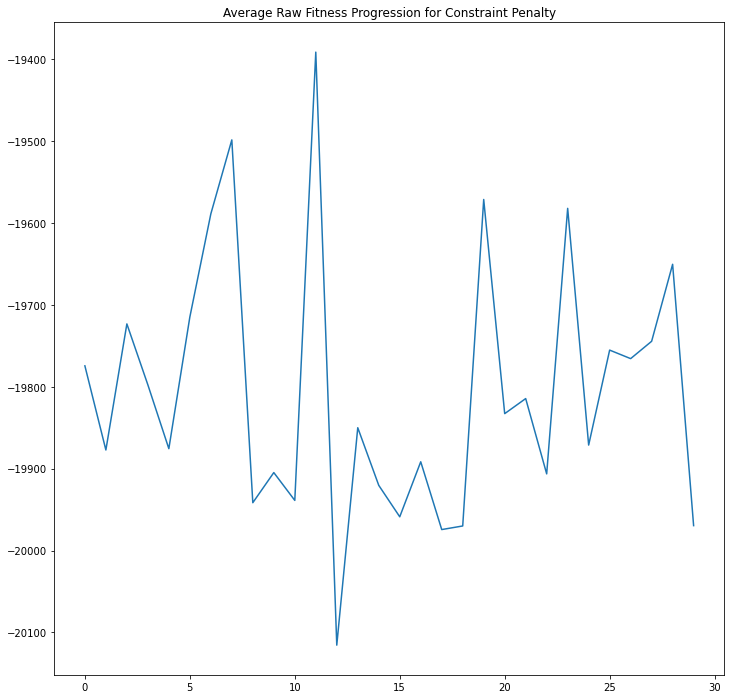

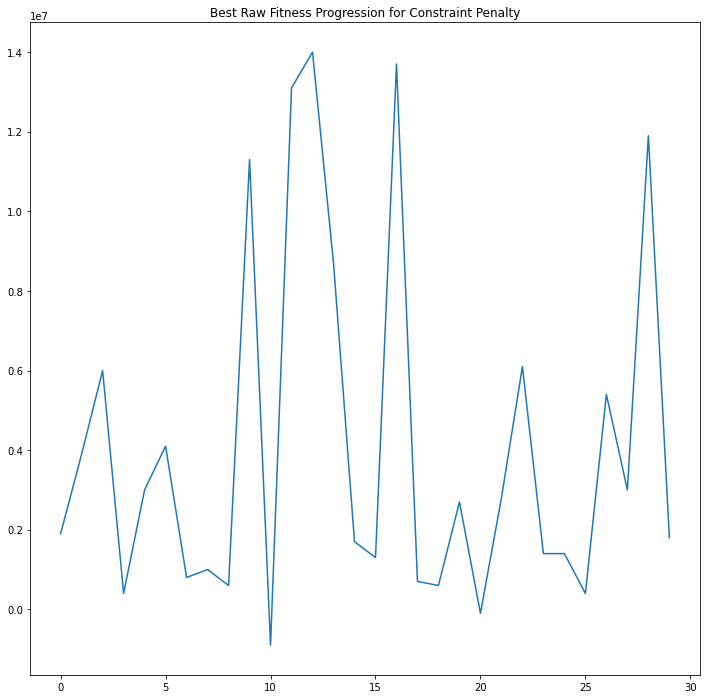

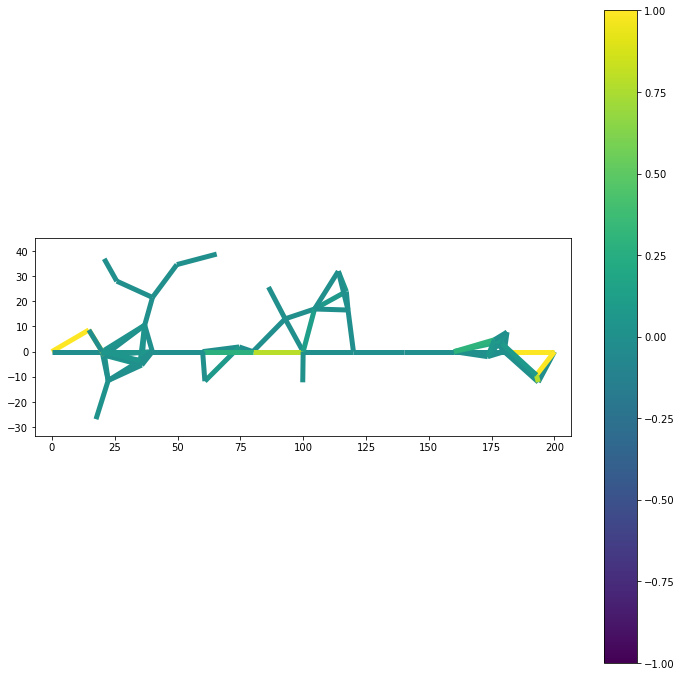

In [34]:
number_runs = 30
number_evaluations = 5000
filepath = 'data/1c_notebook0/penalty/'

# You can parse different configuration files here as necessary
config_filename = './configs/green1c0_penalty_config.txt'

runDataList = []

# implement your multi-run experiment here
for count in range(number_runs):
    runDataList.append(constraint_satisfaction_EA_search(count, number_evaluations, config_filename))
    print(f'Finished run # {count}')
    
averages = [runData[1] for runData in runDataList]

plt.figure()
plt.title('Average Raw Fitness Progression for Constraint Penalty')
plt.plot(range(number_runs), averages)
plt.savefig(filepath + 'constraintPenaltyAverageRawFitness.png')
    
fitnesses = [runData[0] for runData in runDataList]

plt.figure()
plt.title('Best Raw Fitness Progression for Constraint Penalty')
plt.plot(range(number_runs), fitnesses)
plt.savefig(filepath + 'constraintPenaltyBestRawFitness.png')

with open(filepath + 'bestfitnesses.txt', 'w') as fp:
    fp.write(f'Best Fitnesses\n')
    for fitness in fitnesses:
        fp.write(f'{fitness}\n')

bestFitness = max(fitnesses)

bestRun = runDataList[fitnesses.index(bestFitness)]

plot_bridge(bestRun[2])



Finished run # 0
Finished run # 1
Finished run # 2
Finished run # 3
Finished run # 4
Finished run # 5
Finished run # 6
Finished run # 7
Finished run # 8
Finished run # 9
Finished run # 10
Finished run # 11
Finished run # 12
Finished run # 13
Finished run # 14
Finished run # 15
Finished run # 16
Finished run # 17
Finished run # 18
Finished run # 19
Finished run # 20
Finished run # 21
Finished run # 22
Finished run # 23
Finished run # 24
Finished run # 25
Finished run # 26
Finished run # 27
Finished run # 28
Finished run # 29


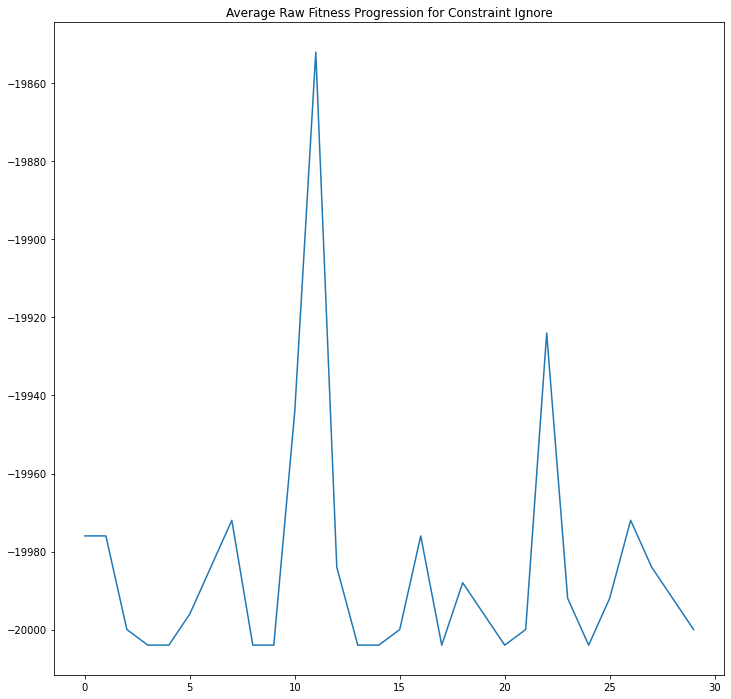

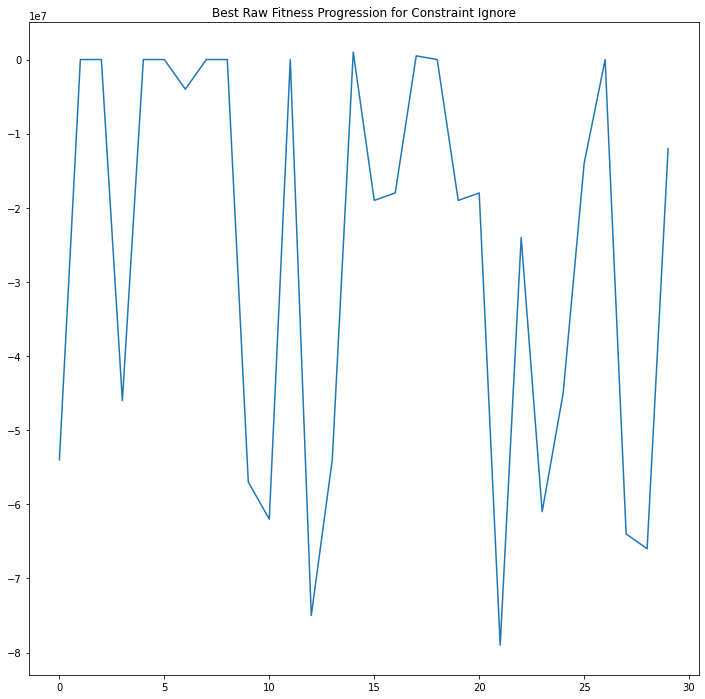

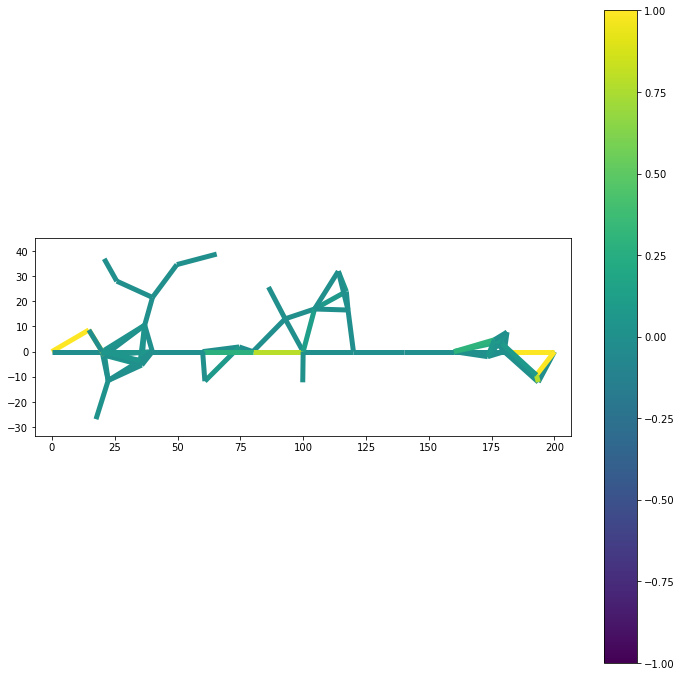

In [35]:
number_runs = 30
number_evaluations = 5000
filepath = 'data/1c_notebook0/ignore/'

# You can parse different configuration files here as necessary
config_filename = './configs/green1c0_ignore_config.txt'

runDataList = []

# implement your multi-run experiment here
for count in range(number_runs):
    runDataList.append(constraint_satisfaction_EA_search(count, number_evaluations, config_filename))
    print(f'Finished run # {count}')
    
averages = [runData[1] for runData in runDataList]

plt.figure()
plt.title('Average Raw Fitness Progression for Constraint Ignore')
plt.plot(range(number_runs), averages)
plt.savefig(filepath + 'constraintIgnoreAverageRawFitness.png')

fitnesses = [runData[0] for runData in runDataList]

plt.figure()
plt.title('Best Raw Fitness Progression for Constraint Ignore')
plt.plot(range(number_runs), fitnesses)
plt.savefig(filepath + 'constraintPenaltyBestRawFitness.png')

with open(filepath + 'bestfitnesses.txt', 'w') as fp:
    fp.write(f'Best Fitnesses\n')
    for fitness in fitnesses:
        fp.write(f'{fitness}\n')

bestFitness = max(fitnesses)

bestRun = runDataList[fitnesses.index(bestFitness)]

plot_bridge(bestRun[2])


## Report
Using the data you've collected from your 30-run experiments, average per-generation across all runs to find the average mean and maximum population fitnesses across 30 runs for each experiment. Using this data, produce a plot that shows the mean and best fitness per number of fitness evaluations averaged over 30 runs. This is the same plot as Assignment 1b. Include this in your report along with any statistical analysis or additional requested components from the assignment description. Statistical analysis should consist of a comparison between best per-run **raw fitness** values from both experiments.